In [1]:
from reader_utils.corpus_builder_utils import *
from note_utils.pitch_dictionary import PitchDictionary
from reader_utils.dataset_builder import DatasetBuilder
from model_utils.model_utils import *
from gensim.models import Word2Vec

import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
pd = PitchDictionary("dataset_objects/pitches_dict.txt")
db = DatasetBuilder("dataset_objects/full_corpus")

In [3]:
raw_corpus_path = "dataset_objects/raw_full_corpus"
raw_corpus = db.read_corpus_from_path(raw_corpus_path)

In [4]:
model = Word2Vec(vector_size=50, window=5, min_count=1, negative=5, epochs=10)

In [5]:
model.build_vocab(raw_corpus)

In [6]:
model.train(raw_corpus, total_examples=model.corpus_count, epochs=10, report_delay=1)

(1964937, 8810820)

In [7]:
# most_similar(positive=["woman", "king"], negative=["man"]) => 
# (king – man) + woman = ?    =>    (king – man) = ? - woman
model.wv.most_similar(positive=["re5", "sol4"], negative=["la4"], topn=3)

[('es', 0.36598077416419983),
 ('si4b1', 0.327953040599823),
 ('do5', 0.2820262610912323)]

In [8]:
X = [model.wv[x] for x in model.wv.index_to_key]

In [9]:
pca = PCA(n_components=2)
result = pca.fit_transform(X)

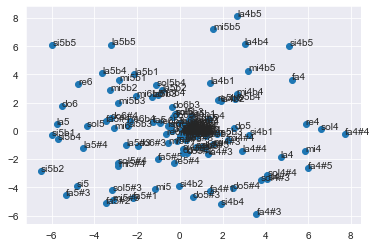

In [10]:
plt.scatter(result[:, 0], result[:, 1])
for i, pitch in enumerate(model.wv.index_to_key):
	plt.annotate(pitch, xy=(result[i, 0], result[i, 1]))

In [11]:
corpus_path_pc = "dataset_objects/raw_full_corpus_pitch_classes"
raw_corpus_pc = db.read_corpus_from_path(corpus_path_pc)

In [21]:
model_pc = Word2Vec(vector_size=20, window=10, min_count=100, negative=5, epochs=10)
model_pc.build_vocab(raw_corpus_pc)

In [22]:
model_pc.train(raw_corpus_pc, total_examples=model_pc.corpus_count, epochs=10, report_delay=1)

(1536571, 8810820)

In [23]:
# most_similar(positive=["woman", "king"], negative=["man"]) => 
# (king – man) + woman = ?    =>    (king – man) = ? - woman
model_pc.wv.most_similar(positive=["re", "sol"], negative=["la"], topn=3)

[('lab4', 0.2546437680721283),
 ('mib2', 0.17125339806079865),
 ('mib4', 0.15874044597148895)]